In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import itertools

In [4]:
## Make folder to save best params
best_param_folder = '/home/erussek/projects/RNNs/best_hyper_params'
if not os.path.exists(best_param_folder):
    os.mkdir(best_param_folder)
best_param_dict = {}

In [5]:
def load_results(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout):
    
    to_save_folder = '/scratch/gpfs/erussek/RNN_project/Control_Models1_HP'
    res_name_full = 'run_{}_fixunit_{}_d_model_{}_sim_lr_{}_human_lr_{}_nsim_{}_nhum_{}_do_{}'.format(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout)

    param_dict = {'fix_unit': fix_unit, 'd_model':d_model, 'sim_lr':sim_lr, 'human_lr':human_lr, 'n_simulation_sequences_train':n_simulation_sequences_train, 'n_human_sequences_train':n_human_sequences_train, 'dropout': dropout}                  
    res_file_name = res_name_full + '.pickle'
    res_full_file_name = os.path.join(to_save_folder, res_file_name)
    file = open(res_full_file_name, 'rb')
    res = pickle.load(file)
    return res, param_dict


def load_results_all_runs(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 20):
    
    results_list = []
    
    for run_idx in range(n_runs):
        res, param_dict = load_results(run_idx, fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout)
        results_list.append(res)
        
    return results_list, param_dict


def get_learning_curve_train_sim_or_human(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 20, which_loss = 'simulation_loss_results'): 
    
    results_list, param_dict = load_results_all_runs(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = n_runs)
    
    loss_results_by_run = np.array([res[which_loss] for res in results_list])
    
    return np.mean(loss_results_by_run, axis=0), np.std(loss_results_by_run, axis=0)/np.sqrt(n_runs), results_list[0]['train_sequence_number'], results_list[0]['simulation_sequence_number'], results_list[0]['human_sequence_number'], param_dict


def get_correlation_results(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, which_r_sim = 'r_sim_by_n_back', n_runs = 20):
    
    results_list, param_dict = load_results_all_runs(fix_unit, d_model, sim_lr, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = n_runs)
        
    r_by_n_back = np.array([res[which_r_sim] for res in results_list])
    
    return np.mean(r_by_n_back, axis=0), np.std(r_by_n_back, axis=0)/np.sqrt(n_runs)

In [6]:
### Train on these vals... 
hidden_sizes = np.array([16]) 
sim_lrs = np.array([1e-3])

# what human lrs to use for training?
human_lrs_train = np.array([ 1e-3])

# what human lrs to use for fine-tuning? # this might not be enough examples??
human_lrs_finetune = np.array([1e-3])
dropout_vals = [0]

# fixation types
fix_units = ['ID', 'sum', 'prop', 'all']

# run this for 1 mil, and also on more jobs...
n_sim_seqs = 5e5
n_human_seqs = 0

# load_results(0, fix_units[0], hidden_sizes[0], sim_lrs[0], 0, n_sim_seqs, n_human_seqs, dropout_vals[0])

In [7]:
def get_best_params(res_losses, res_params, model_name, simulation_sequence_number, human_sequence_number):
    loss_arr = np.array(res_losses[model_name])
    
    min_val = np.min(loss_arr)
    
    min_flat_idx = np.argmin(loss_arr)
    (min_train_setting_idx,min_train_num_idx) = divmod(min_flat_idx, loss_arr.shape[1])

    best_params = res_params[model_name][min_train_setting_idx]
    
    # this seems wrong...
    best_params['best_sim_num'] = simulation_sequence_number[min_train_num_idx]
    best_params['best_hum_num'] = human_sequence_number[min_train_num_idx]

    best_params['min_loss'] = min_val
    
    return best_params

ID : {'fix_unit': 'ID', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 300832, 'best_hum_num': 0, 'min_loss': 5.177939941485723} 

sum : {'fix_unit': 'sum', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 499232, 'best_hum_num': 0, 'min_loss': 4.933974519371986} 

prop : {'fix_unit': 'prop', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 409632, 'best_hum_num': 0, 'min_loss': 5.055445109804471} 

all : {'fix_unit': 'all', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 403232, 'best_hum_num': 0, 'min_loss': 4.896022737026215} 



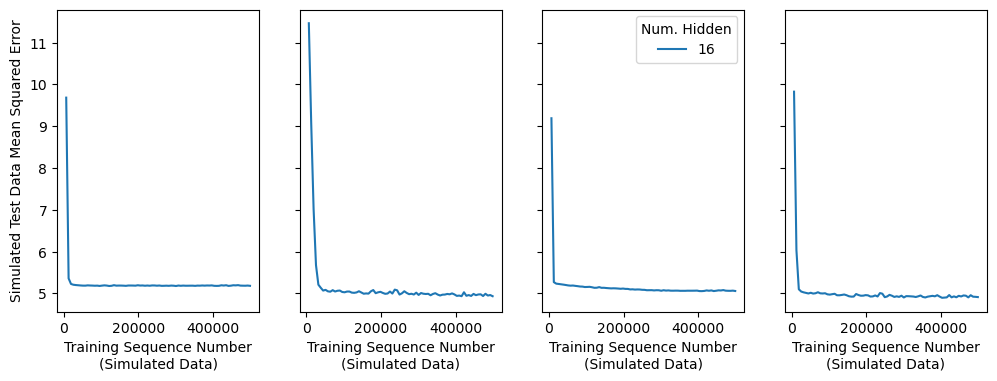

In [9]:
res_params = {}
res_losses = {}
for m_name in fix_units:
    res_params[m_name] = []
    res_losses[m_name] = []

n_simulation_sequences_train = 5e5
n_human_sequences_train = 0

fig,ax = plt.subplots(1,4, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for fu_idx,fu in enumerate(fix_units):
    for sim_lr_idx, sim_lr in enumerate(sim_lrs):
        for d_model in hidden_sizes:
            for dropout in [0]:
                mean_loss, sem_loss, train_sequence_number, simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(fu, d_model, sim_lr, 0, n_simulation_sequences_train, n_human_sequences_train, dropout, n_runs = 3)                
                ax[fu_idx].plot(train_sequence_number, mean_loss, label = d_model)
                # ax[fu_idx].errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                ax[fu_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');

                res_losses[fu].append(mean_loss)
                res_params[fu].append(res_name)
                
best_params_train_sim_test_sim = {}
for model_name in fix_units:
    best_params = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params))
    best_params_train_sim_test_sim[model_name] = get_best_params(res_losses,res_params, model_name, train_sequence_number, human_sequence_number)
ax[2].legend(title = "Num. Hidden")
ax[0].set_ylabel('Simulated Test Data Mean Squared Error');  

In [10]:
best_params_train_sim_test_sim

{'ID': {'fix_unit': 'ID',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0,
  'n_simulation_sequences_train': 500000.0,
  'n_human_sequences_train': 0,
  'dropout': 0,
  'best_sim_num': 300832,
  'best_hum_num': 0,
  'min_loss': 5.177939941485723},
 'sum': {'fix_unit': 'sum',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0,
  'n_simulation_sequences_train': 500000.0,
  'n_human_sequences_train': 0,
  'dropout': 0,
  'best_sim_num': 499232,
  'best_hum_num': 0,
  'min_loss': 4.933974519371986},
 'prop': {'fix_unit': 'prop',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0,
  'n_simulation_sequences_train': 500000.0,
  'n_human_sequences_train': 0,
  'dropout': 0,
  'best_sim_num': 409632,
  'best_hum_num': 0,
  'min_loss': 5.055445109804471},
 'all': {'fix_unit': 'all',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0,
  'n_simulation_sequences_train': 500000.0,
  'n_human_sequences_train': 0,
  'dropout': 0,
  'best_sim_num': 403232,
  'best_hum_num': 0,
  'min_loss': 4.89

#### Results for train sim / test human

ID : {'fix_unit': 'ID', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 243232, 'best_hum_num': 0, 'min_loss': 5.791236385703087} 

sum : {'fix_unit': 'sum', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 243232, 'best_hum_num': 0, 'min_loss': 5.86288084089756} 

prop : {'fix_unit': 'prop', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 147232, 'best_hum_num': 0, 'min_loss': 5.800855095187823} 

all : {'fix_unit': 'all', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0, 'n_simulation_sequences_train': 500000.0, 'n_human_sequences_train': 0, 'dropout': 0, 'best_sim_num': 243232, 'best_hum_num': 0, 'min_loss': 5.881157204508781} 



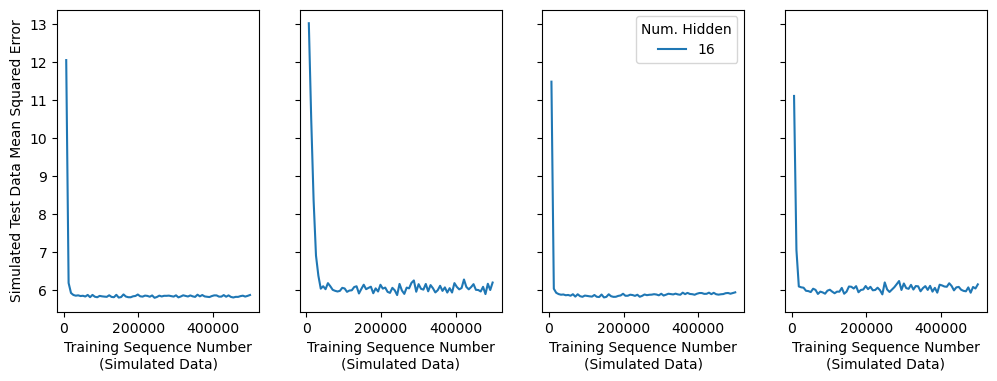

In [12]:
res_params = {}
res_losses = {}
for m_name in fix_units:
    res_params[m_name] = []
    res_losses[m_name] = []

n_simulation_sequences_train = 5e5
n_human_sequences_train = 0

fig,ax = plt.subplots(1,4, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for fu_idx,fu in enumerate(fix_units):
    for sim_lr_idx, sim_lr in enumerate(sim_lrs):
        for d_model in hidden_sizes:
            for dropout in [0]:
                mean_loss, sem_loss, train_sequence_number, simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(fu, d_model, sim_lr, 0, n_simulation_sequences_train, n_human_sequences_train, dropout, which_loss= 'human_loss_results', n_runs = 3)                
                ax[fu_idx].plot(train_sequence_number, mean_loss, label = d_model)
                # ax[fu_idx].errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                ax[fu_idx].set_xlabel('Training Sequence Number\n(Simulated Data)');

                res_losses[fu].append(mean_loss)
                res_params[fu].append(res_name)
                
best_params_train_sim_test_human = {}
for model_name in fix_units:
    best_params = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params))
    best_params_train_sim_test_human[model_name] = get_best_params(res_losses,res_params, model_name, train_sequence_number, human_sequence_number)
ax[2].legend(title = "Num. Hidden")
ax[0].set_ylabel('Simulated Test Data Mean Squared Error');  

#### Results for train human / test human

ID : {'fix_unit': 'ID', 'd_model': 16, 'sim_lr': 0, 'human_lr': 0.001, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 0, 'best_hum_num': 147200, 'min_loss': 5.6984386791785555} 

sum : {'fix_unit': 'sum', 'd_model': 16, 'sim_lr': 0, 'human_lr': 0.001, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 0, 'best_hum_num': 460800, 'min_loss': 5.689634293317795} 

prop : {'fix_unit': 'prop', 'd_model': 16, 'sim_lr': 0, 'human_lr': 0.001, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 0, 'best_hum_num': 473600, 'min_loss': 5.686443900068601} 

all : {'fix_unit': 'all', 'd_model': 32, 'sim_lr': 0, 'human_lr': 0.0005, 'n_simulation_sequences_train': 0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 0, 'best_hum_num': 473600, 'min_loss': 5.655343234539032} 



(5.0, 7.5)

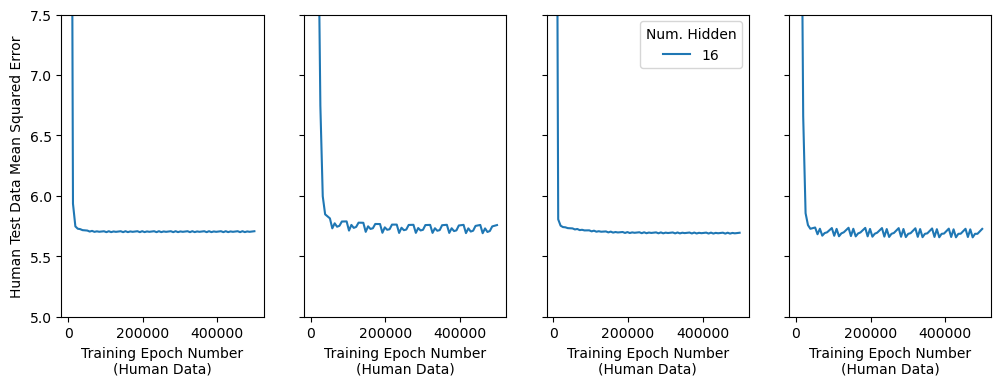

In [18]:
res_params = {}
res_losses = {}
for m_name in fix_units:
    res_params[m_name] = []
    res_losses[m_name] = []

n_simulation_sequences_train = 0
n_human_sequences_train = 5e5

fig,ax = plt.subplots(1,4, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for fu_idx,fu in enumerate(fix_units):
    if fu_idx > -1:
        for sim_lr_idx, human_lr in enumerate(human_lrs_train):
            for d_model in hidden_sizes:
                for dropout in [0]:
                    if fu == 'all':
                        this_human_lr = 5e-4
                        this_human_dmodel = 32
                    else:
                        this_human_lr = human_lr
                        this_human_dmodel = d_model
                    
                    mean_loss, sem_loss, train_sequence_number, simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(fu, this_human_dmodel, 0, this_human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, which_loss= 'human_loss_results', n_runs = 3)                
                    ax[fu_idx].plot(train_sequence_number, mean_loss, label = d_model)
                    # ax[fu_idx].errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                    ax[fu_idx].set_xlabel('Training Epoch Number\n(Human Data)');

                    res_losses[fu].append(mean_loss)
                    res_params[fu].append(res_name)
                
best_params_train_human_test_human = {}
for model_name in fix_units:
    best_params = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params))
    best_params_train_human_test_human[model_name] = get_best_params(res_losses,res_params, model_name, train_sequence_number, human_sequence_number)
ax[2].legend(title = "Num. Hidden")
ax[0].set_ylabel('Human Test Data Mean Squared Error');  
ax[0].set_ylim(5,7.5)

sum : {'fix_unit': 'sum', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0.001, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 294432, 'best_hum_num': 102400, 'min_loss': 5.6823335736989975} 

prop : {'fix_unit': 'prop', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0.001, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 294432, 'best_hum_num': 460800, 'min_loss': 5.688632537921269} 

all : {'fix_unit': 'all', 'd_model': 16, 'sim_lr': 0.001, 'human_lr': 0.001, 'n_simulation_sequences_train': 300000.0, 'n_human_sequences_train': 500000.0, 'dropout': 0, 'best_sim_num': 294432, 'best_hum_num': 473600, 'min_loss': 5.6630656371514005} 



(5.0, 7.5)

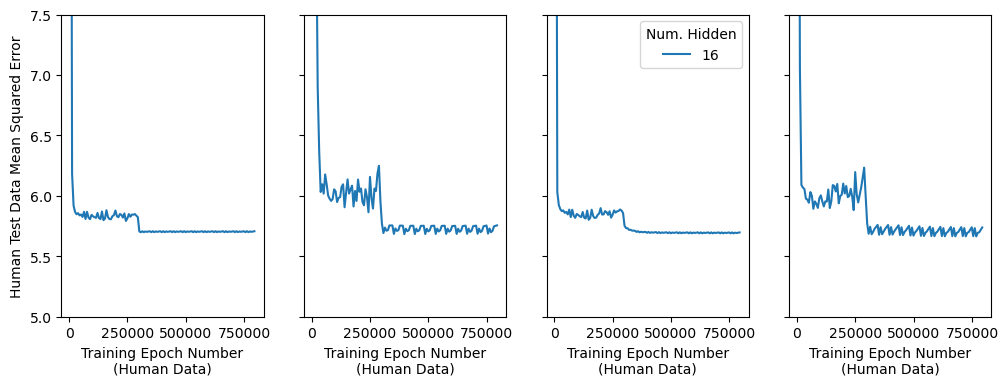

In [13]:
res_params = {}
res_losses = {}
for m_name in fix_units:
    res_params[m_name] = []
    res_losses[m_name] = []

n_simulation_sequences_train = 3e5
n_human_sequences_train = 5e5

fig,ax = plt.subplots(1,4, figsize = (12,4), dpi = 100, sharex = True, sharey = True)
for fu_idx,fu in enumerate(fix_units):
    for sim_lr_idx, human_lr in enumerate(human_lrs_train):
        for d_model in hidden_sizes:
            for dropout in [0]:
                mean_loss, sem_loss, train_sequence_number, simulation_sequence_number, human_sequence_number, res_name = get_learning_curve_train_sim_or_human(fu, d_model, .001, human_lr, n_simulation_sequences_train, n_human_sequences_train, dropout, which_loss= 'human_loss_results', n_runs = 3)                
                ax[fu_idx].plot(train_sequence_number, mean_loss, label = d_model)
                # ax[fu_idx].errorbar(train_sequence_number, mean_loss, yerr=sem_loss)
                ax[fu_idx].set_xlabel('Training Epoch Number\n(Human Data)');

                res_losses[fu].append(mean_loss)
                res_params[fu].append(res_name)
                
best_params_train_sim_test_sim = {}
for model_name in fix_units[1:]:
    best_params = get_best_params(res_losses,res_params, model_name, simulation_sequence_number, human_sequence_number)
    print('{} : {} \n'.format(model_name, best_params))
    best_params_train_sim_test_sim[model_name] = get_best_params(res_losses,res_params, model_name, train_sequence_number, human_sequence_number)
ax[2].legend(title = "Num. Hidden")
ax[0].set_ylabel('Human Test Data Mean Squared Error');  
ax[0].set_ylim(5,7.5)

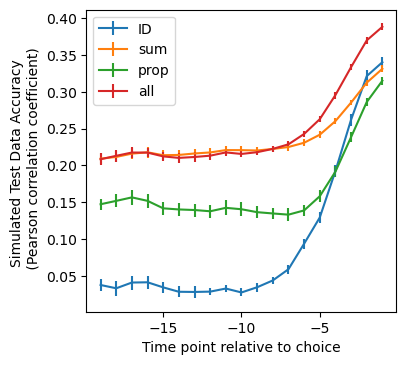

In [19]:

fig,ax = plt.subplots(1, figsize = (4,4), dpi = 100, sharex = True, sharey = True)

for fu_idx,fu in enumerate(fix_units):
    bp = best_params_train_sim_test_sim[fu]

    mn_r_by_n_back, sem_r = get_correlation_results(fu, 16, .001, 0, 5e5, 0, 0, which_r_sim = 'r_sim_by_n_back', n_runs = 20)
    these_tps = np.arange(-19,0,1)
    ax.errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = fu)
    
    # ax.set_title(fu)
    ax.set_xlabel('Time point relative to choice')
    
ax.set_ylabel('Simulated Test Data Accuracy \n (Pearson correlation coefficient)');

ax.legend()

In [15]:
best_params_train_sim_test_sim

{'sum': {'fix_unit': 'sum',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0.001,
  'n_simulation_sequences_train': 300000.0,
  'n_human_sequences_train': 500000.0,
  'dropout': 0,
  'best_sim_num': 396832,
  'best_hum_num': 102400,
  'min_loss': 5.6823335736989975},
 'prop': {'fix_unit': 'prop',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0.001,
  'n_simulation_sequences_train': 300000.0,
  'n_human_sequences_train': 500000.0,
  'dropout': 0,
  'best_sim_num': 755232,
  'best_hum_num': 460800,
  'min_loss': 5.688632537921269},
 'all': {'fix_unit': 'all',
  'd_model': 16,
  'sim_lr': 0.001,
  'human_lr': 0.001,
  'n_simulation_sequences_train': 300000.0,
  'n_human_sequences_train': 500000.0,
  'dropout': 0,
  'best_sim_num': 768032,
  'best_hum_num': 473600,
  'min_loss': 5.6630656371514005}}

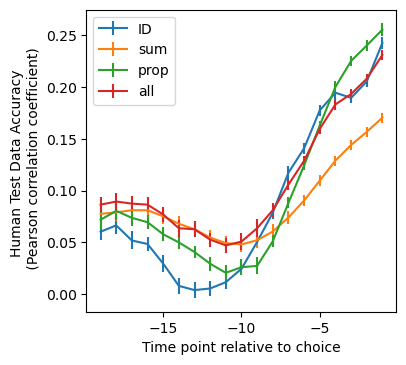

In [20]:

fig,ax = plt.subplots(1, figsize = (4,4), dpi = 100, sharex = True, sharey = True)

for fu_idx,fu in enumerate(fix_units):
    bp = best_params_train_human_test_human[fu]

    mn_r_by_n_back, sem_r = get_correlation_results(fu, bp['d_model'], 0, bp['human_lr'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], which_r_sim = 'r_human_by_n_back', n_runs = 20)
    these_tps = np.arange(-19,0,1)
    ax.errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = fu)
    
    # ax.set_title(fu)
    ax.set_xlabel('Time point relative to choice')
    
ax.set_ylabel('Human Test Data Accuracy \n (Pearson correlation coefficient)');

ax.legend()
    


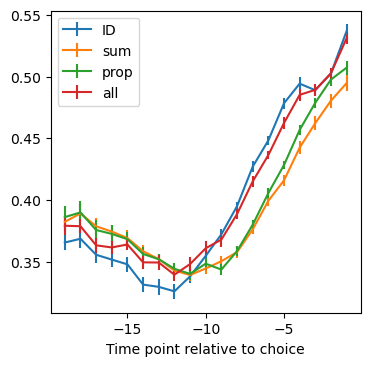

In [21]:

fig,ax = plt.subplots(1, figsize = (4,4), dpi = 100, sharex = True, sharey = True)

for fu_idx,fu in enumerate(fix_units):
    bp = best_params_train_human_test_human[fu]

    mn_r_by_n_back, sem_r = get_correlation_results(fu, bp['d_model'], 0, bp['human_lr'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], which_r_sim = 'pct_correct_max_human_by_n_back', n_runs = 20)
    these_tps = np.arange(-19,0,1)
    ax.errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = fu)
    
    # ax.set_title(fu)
    ax.set_xlabel('Time point relative to choice')
    

ax.legend()
    


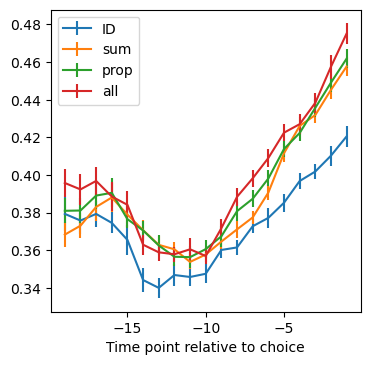

In [22]:

fig,ax = plt.subplots(1, figsize = (4,4), dpi = 100, sharex = True, sharey = True)

for fu_idx,fu in enumerate(fix_units):
    bp = best_params_train_human_test_human[fu]

    mn_r_by_n_back, sem_r = get_correlation_results(fu, bp['d_model'], 0, bp['human_lr'], bp['n_simulation_sequences_train'], bp['n_human_sequences_train'], bp['dropout'], which_r_sim = 'pct_correct_min_human_by_n_back', n_runs = 20)
    these_tps = np.arange(-19,0,1)
    ax.errorbar(these_tps,np.flip(mn_r_by_n_back), yerr=np.flip(sem_r), label = fu)
    
    # ax.set_title(fu)
    ax.set_xlabel('Time point relative to choice')
    

ax.legend()
    
